<a id='Top'></a>
# Using Satellite Imagery to Identify Solar Panel Arrays

# Introduction

Over the last decade, U.S. residential and commercial solar panel installations have grown dramatically. This is in large part due significant reductions in cost, but also because of growing concerns regarding climate change. In the last ten years, solar installation costs have fallen by over 70% and they continue to improve. 

The full extent of this growth, however, is not well understood as the data for residential and commercial solar installations is typically reported only at the level of the state. Having a more granular dataset would benefit a number of parties, including utilities, policy makers, and solar developers. Utilities, in particular, will face many challenges integrating such a high amount of distributed generation and therefore will benefit greatly from understanding the magnitude and distribution of these resources. 

The goal of this project is to identify solar panel arrays in high resolution satellite imagery using machine learning techniques. Specifically, I will divide images into segments by grouping similar pixels together, calculate features for each image segment, and train a classifier to differentiate solar panel regions from non-solar panel regions. 

## Dataset

In this analysis, I will utilize a dataset created by the Energy Data Analytics Lab at Duke University. The dataset contains geospatial data and border vertices for over 19,000 solar panels, located in the California cities of Fresno, Stockton, Oxnard, and Modesto. The full dataset of images and annotations can be found [here](https://figshare.com/collections/Full_Collection_Distributed_Solar_Photovoltaic_Array_Location_and_Extent_Data_Set_for_Remote_Sensing_Object_Identification/3255643/1). 

The satellite images are part of the USGS collection of High Resolution Orthoimagery (HRO). The majority of the raw images are 5000x5000 pixels, at a resolution of 0.3m/pixel. Although the USGS High Resolution database does not encompass the entire U.S., it does cover many urban areas in the country and continues to grow as the agency acquires new data. 

# Table of Contents
- <a href='#Section 1'>Section 1: Data Munging</a>
- <a href='#Section 2'>Section 2: Ground Truth Data</a>
- <a href='#Section 3'>Section 3: Image Segmentation</a>
- <a href='#Section 4'>Section 4: Feature Extraction</a>
- <a href='#Section 5'>Section 5: Building a Dataset</a>
- <a href='#Section 6'>Section 6: Classification</a>
- <a href='#Section 7'>Section 7: Conclusion and Next Steps</a>

### Import Modules

In [2]:
import pandas as pd
import numpy as np

from scipy.stats import describe

from skimage.segmentation import quickshift, mark_boundaries 
from skimage.draw import polygon, polygon_perimeter
from skimage import measure
from skimage import io

from matplotlib.patches import Circle, Polygon
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from ipywidgets import interact, fixed
from os import listdir

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
pip install scikit-image

  Using cached scikit_image-0.24.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (14 kB)
  Using cached imageio-2.34.2-py3-none-any.whl.metadata (4.9 kB)
  Using cached tifffile-2024.7.2-py3-none-any.whl.metadata (30 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
Using cached scikit_image-0.24.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (14.9 MB)
Using cached imageio-2.34.2-py3-none-any.whl (313 kB)
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
Using cached tifffile-2024.7.2-py3-none-any.whl (225 kB)
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 15.0 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


### Import Raw Data

In [3]:
raw_data_1 = ('/home/jovyan/shared/Learning materials/subsections/1.*/data/1.1.1Identify_Solar_Panel/polygonDataExceptVertices.csv')
raw_data_2 = ('/home/jovyan/shared/Learning materials/subsections/1.*/data/1.1.1Identify_Solar_Panel/polygonVertices_PixelCoordinates.csv')

arrays = pd.read_csv(raw_data_1)
vertices_pix = pd.read_csv(raw_data_2)

In [4]:
arrays.head()

Unnamed: 0  polygon_id  centroid_latitude  centroid_longitude  \
0           0           1          36.926310         -119.840555   
1           1           2          36.926477         -119.840561   
2           2           3          36.926542         -119.840506   
3           3           4          36.921008         -119.842847   
4           4           5          36.920976         -119.842906   

   centroid_latitude_pixels  centroid_longitude_pixels    city  area_pixels  \
0                107.618458                3286.151487  Fresno  1513.254134   
1                 45.977659                3286.352946  Fresno  1727.907934   
2                 22.280851                3303.465657  Fresno  1242.184349   
3               2048.362567                2547.366116  Fresno   688.933420   
4               2060.014890                2529.504997  Fresno  1060.890554   

   area_meters   image_name  nw_corner_of_image_latitude  \
0   136.192872  11ska460890                    36.926336   
1   155.511714  11ska460890                    36.926336   
2   111.796591  11ska460890                    36.926336   
3    62.004008  11ska460890                    36.926336   
4    95.480150  11ska460890                    36.926336   

   nw_corner_of_image_longitude  se_corner_of_image_latitude  \
0                   -119.851622                    36.913233   
1                   -119.851622                    36.913233   
2                   -119.851622                    36.913233   
3                   -119.851622                    36.913233   
4                   -119.851622                    36.913233   

   se_corner_of_image_longitude  datum  projection_zone  resolution  \
0                     -119.8343  NAD83               11         0.3   
1                     -119.8343  NAD83               11         0.3   
2                     -119.8343  NAD83               11         0.3   
3                     -119.8343  NAD83               11         0.3   
4                     -119.8343  NAD83               11         0.3   

   jaccard_index  
0       0.914020  
1       0.829071  
2       0.937961  
3       0.842634  
4       0.890998

<a href='#Top'>Back to Top</a>
<a id='Section 1'></a>

# Section 1: Data Munging
The main cleaning operation is on the vertices_pix data. This table contains an ID ('dataPolygonsPixels1') for each solar panel as well as the corresponding vertices. Each x, y point in the vertices is broken out into a seperate column. To make the analysis easier, I will convert these into a single coordinates list. 

In [5]:
vertices_pix.head()

polygon_id  number_vertices         lon1         lat1         lon2  \
0           1                8  3360.495069   131.631164  3249.197710   
1           2                9  3361.153846    69.615385  3217.615385   
2           3               11  3358.015726    48.136863  3358.050000   
3           4                9  2571.591716  2068.049310  2571.021266   
4           5                9  2563.781065  2091.398422  2504.416174   

          lat2         lon3         lat3         lon4         lat4  ...  \
0    87.985141  3213.750000    73.850000  3210.450000    81.950000  ...   
1    12.846154  3217.440417    13.096107  3215.850000    12.450000  ...   
2    48.150000  3360.742998    42.379290  3362.122288    39.467456  ...   
3  2067.393899  2571.350000  2067.150000  2531.150000  2021.550000  ...   
4  2021.674556  2503.979640  2022.048728  2503.550000  2021.550000  ...   

   lon142  lat142  lon143  lat143  lon144  lat144  lon145  lat145  lon146  \
0     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

   lat146  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN  

[5 rows x 294 columns]

In [7]:
print(arrays.columns)

Index(['Unnamed: 0', 'polygon_id', 'centroid_latitude', 'centroid_longitude',
       'centroid_latitude_pixels', 'centroid_longitude_pixels', 'city',
       'area_pixels', 'area_meters', 'image_name',
       'nw_corner_of_image_latitude', 'nw_corner_of_image_longitude',
       'se_corner_of_image_latitude', 'se_corner_of_image_longitude', 'datum',
       'projection_zone', 'resolution', 'jaccard_index'],
      dtype='object')


In [8]:
print(vertices_pix.columns)

Index(['polygon_id', 'number_vertices', 'lon1', 'lat1', 'lon2', 'lat2', 'lon3',
       'lat3', 'lon4', 'lat4',
       ...
       'lon142', 'lat142', 'lon143', 'lat143', 'lon144', 'lat144', 'lon145',
       'lat145', 'lon146', 'lat146'],
      dtype='object', length=294)


In [17]:
import pandas as pd

def extract_vertices(df):
    # Print the columns to verify their names
    print("Columns in DataFrame:", df.columns)
    
    # Adjust the column names if necessary
    # Assuming 'dataPolygonsPixels1' and 'dataPolygonsPixels2' are not in the DataFrame, replace them with actual column names
    polygon_id = ['dataPolygonsPixels1', 'dataPolygonsPixels2']  # Replace with actual column names if different
    
    # Create melted version of vertices_pix dataframe and clean
    pix = pd.melt(df, polygon_id=polygon_id)
    pix = pix.dropna()
    pix['value'] = pix['value'].map(lambda x: int(round(x)))
    
    return pix

# Use the function
vertices_pix_clean = extract_vertices(vertices_pix)


Columns in DataFrame: Index(['polygon_id', 'number_vertices', 'lon1', 'lat1', 'lon2', 'lat2', 'lon3',
       'lat3', 'lon4', 'lat4',
       ...
       'lon142', 'lat142', 'lon143', 'lat143', 'lon144', 'lat144', 'lon145',
       'lat145', 'lon146', 'lat146'],
      dtype='object', length=294)


TypeError: melt() got an unexpected keyword argument 'polygon_id'

In [18]:
# Function to clean polygon vertices data 

def extract_vertices(df):
    
    # Create melted version of vertices_pix dataframe and clean
    pix = pd.melt(df, id_vars=['dataPolygonsPixels1','dataPolygonsPixels2'])
    pix = pix.dropna()
    pix['value'] = pix['value'].map(lambda x: int(round(x)))
    pix['pixel_id'] = pix['variable'].map(lambda x: int(x.replace(' ','').split('_')[1]))
    pix.drop('variable', axis=1, inplace=True)
    
    # Assign each row with the pair it belongs to 
    pairs = zip(range(1,292,2), range(2,293,2))
    pairs = [pair for double in zip(pairs, pairs) for pair in double]    
    pix['pair'] = pix['pixel_id'].map(lambda x: pairs[x - 1])
    
    # Seperate odd/even and merge together
    even = pix[(pix['pixel_id'] % 2 == 0)]
    odd = pix[~(pix['pixel_id'] % 2 == 0)]
    
    pix_merge = odd.merge(even, on=['dataPolygonsPixels1','dataPolygonsPixels2','pair'])
    pix_merge['coordinate'] = map(lambda x, y: (x, y), pix_merge['value_x'].values, pix_merge['value_y'].values)
    
    # Recombine all coordinate pairs by polygon id 
    polygon_coords = pix_merge[['dataPolygonsPixels1','coordinate']]
    polygon_coords = pd.pivot_table(polygon_coords, index='dataPolygonsPixels1', values='coordinate',
                                aggfunc=lambda x: x.values.tolist())
    
    polygon_coords = polygon_coords.reset_index()
    polygon_coords.columns = ['polygon_id','polygon_vertices']
    
    return polygon_coords

In [19]:
vertices_pix_clean = extract_vertices(vertices_pix)

TypeError: melt() got an unexpected keyword argument 'polygon_id'

In [29]:
vertices_pix_clean.head()

NameError: name 'vertices_pix_clean' is not defined

### Merge the consolidated vertices with the arrays dataframe. 

In [17]:
arrays_clean = arrays.merge(vertices_pix_clean, how='inner', on='polygon_id')
arrays_clean = arrays_clean[['polygon_id', 'centroid_latitude_pixels', 'centroid_longitude_pixels', 'city', 
                            'image_name', 'polygon_vertices']]

NameError: name 'vertices_pix_clean' is not defined

<a href='#Top'>Back to Top</a>
<a id='Section 2'></a>

# Section 2: Ground Truth Data

In [10]:
arrays_clean.head()

polygon_id  centroid_latitude_pixels  centroid_longitude_pixels    city  \
0           1                107.618458                3286.151487  Fresno   
1           2                 45.977659                3286.352946  Fresno   
2           3                 22.280851                3303.465657  Fresno   
3           4               2048.362567                2547.366116  Fresno   
4           5               2060.014890                2529.504997  Fresno   

    image_name                                   polygon_vertices  
0  11ska460890  [(132, 3360), (88, 3249), (74, 3214), (82, 321...  
1  11ska460890  [(70, 3361), (13, 3218), (13, 3217), (12, 3216...  
2  11ska460890  [(48, 3358), (48, 3358), (42, 3361), (39, 3362...  
3  11ska460890  [(2068, 2572), (2067, 2571), (2067, 2571), (20...  
4  11ska460890  [(2091, 2564), (2022, 2504), (2022, 2504), (20...

In [11]:
arrays_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19863 entries, 0 to 19862
Data columns (total 6 columns):
polygon_id                   19863 non-null int64
centroid_latitude_pixels     19861 non-null float64
centroid_longitude_pixels    19861 non-null float64
city                         19863 non-null object
image_name                   19863 non-null object
polygon_vertices             19863 non-null object
dtypes: float64(2), int64(1), object(3)
memory usage: 1.1+ MB


In [12]:
# Count of array annotations and satellite images for each city in the dataset

poly_agg = arrays_clean.groupby(['city','image_name'])[['polygon_id']].count().reset_index()
array_agg = poly_agg.groupby('city')[['image_name']].count().reset_index()
array_agg = array_agg.merge(poly_agg.groupby('city')[['polygon_id']].sum().reset_index())
array_agg = array_agg.sort_values(by='image_name', ascending=False)
array_agg

city  image_name  polygon_id
0    Fresno         312       14803
3  Stockton          85        2682
2    Oxnard          52        1765
1   Modesto          19         613

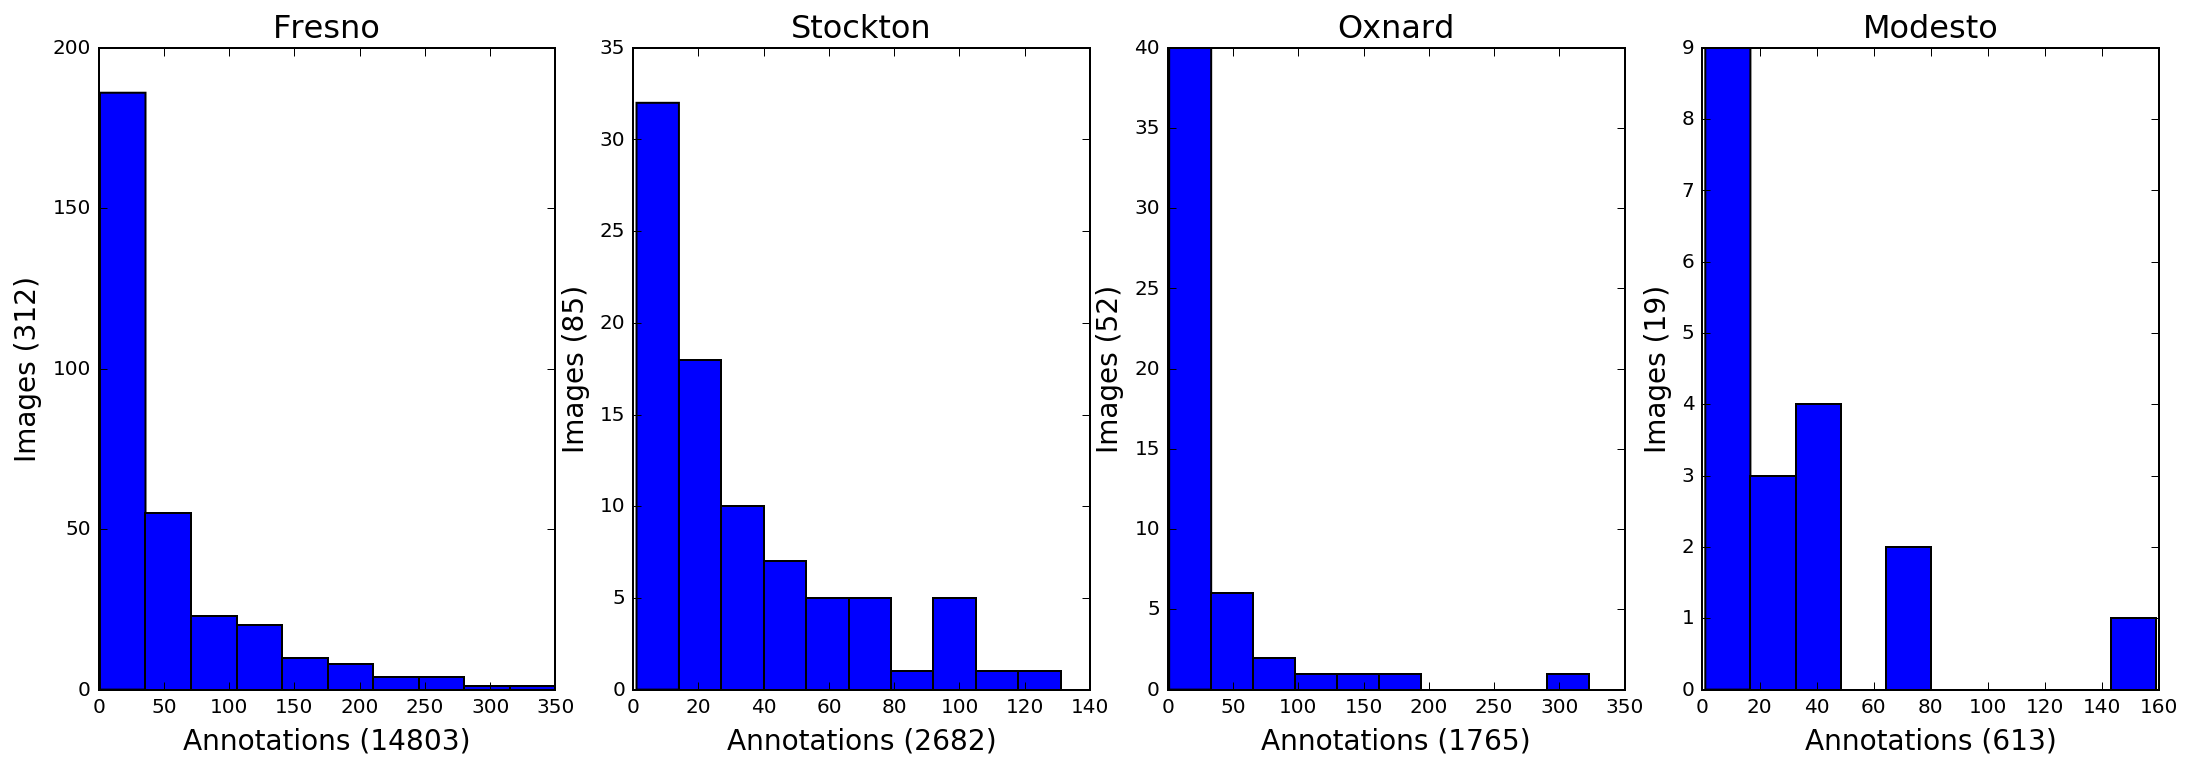

In [13]:
# Distribution of annotations per image, by city 

cities = array_agg['city'].unique()

fig, ax = plt.subplots(1, len(cities), figsize=(15,5))
fig.tight_layout()

for i, city in enumerate(cities):
    annotations = array_agg[array_agg['city'] == city]['polygon_id'].values[0]
    images = array_agg[array_agg['city'] == city]['image_name'].values[0]
    
    ax[i].hist(arrays[arrays['city'] == city]['image_name'].value_counts())
    ax[i].set_title(city, fontsize=16)
    
    ax[i].set_xlabel('Annotations (' + str(annotations) + ')', fontsize=14)
    ax[i].set_ylabel('Images (' + str(images) + ')', fontsize=14)

The above chart reflects the annotations for the entire dataset. Due to size constraints, however, a subset of the dataset was used for this analysis. This subset contains all cities except Fresno. 

In [14]:
# Stockton and Oxnard Datasets are partially incomplete. Creating list of available images. 

avail_files = []

for city in cities: 

    path = '/Users/alexanderhalcomb/Desktop/SolarPV/Datasets/Duke %s/' % (city)
    try:
        avail_files.extend(listdir(path))
    except:
        continue

avail_files = [name[:-4] for name in avail_files if name[-4:] == '.tif']

In [16]:
#  Count of array annotations and satellite images for each city in the dataset

avail_arrays = arrays_clean[arrays_clean['image_name'].isin(avail_files)]

avail_poly_agg = avail_arrays.groupby(['city','image_name'])[['polygon_id']].count().reset_index()
avail_array_agg = avail_poly_agg.groupby('city')[['image_name']].count().reset_index()
avail_array_agg = avail_array_agg.merge(avail_poly_agg.groupby('city')[['polygon_id']].sum().reset_index())
avail_array_agg = avail_array_agg.sort_values(by='image_name', ascending=False)
avail_array_agg

city  image_name  polygon_id
2  Stockton          54        2018
1    Oxnard          39        1422
0   Modesto          19         613

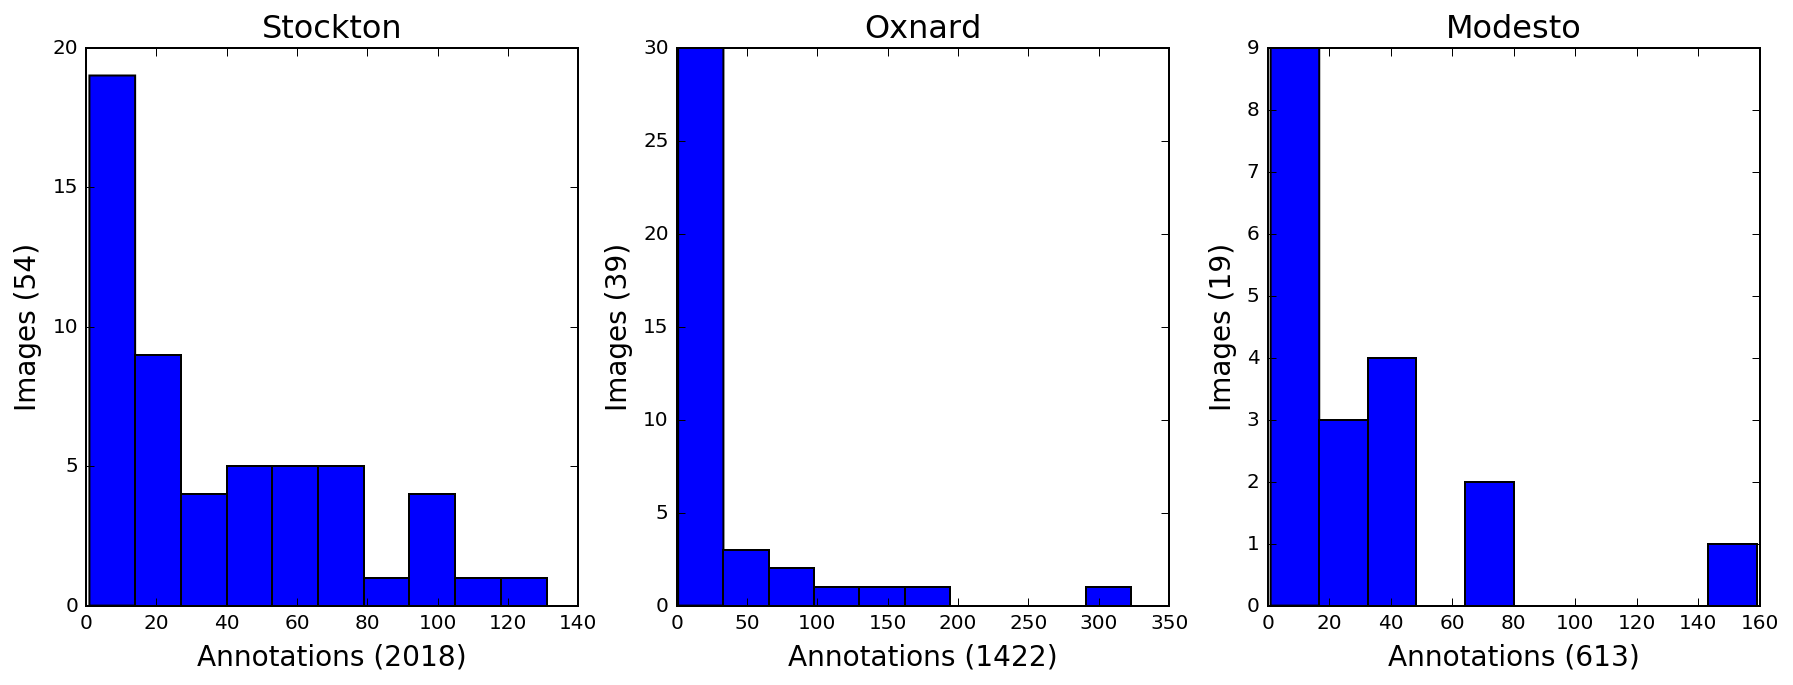

In [17]:
# Distribution of annotations per image, by city 

avail_cities = [city for city in cities if city != 'Fresno']

fig, ax = plt.subplots(1, len(avail_cities), figsize=(15,5))

for i, city in enumerate(avail_cities):
    annotations = avail_array_agg[avail_array_agg['city'] == city]['polygon_id'].values[0]
    images = avail_array_agg[avail_array_agg['city'] == city]['image_name'].values[0]
    
    ax[i].hist(avail_arrays[avail_arrays['city'] == city]['image_name'].value_counts())
    ax[i].set_title(city, fontsize=16)
    
    ax[i].set_xlabel('Annotations (' + str(annotations) + ')', fontsize=14)
    ax[i].set_ylabel('Images (' + str(images) + ')', fontsize=14)

In [18]:
# Plot centers of all solar arrays for a given satellite image

def plot_centroids(img_id):
    
    # Use img_id to create path to correct directory 
    city = arrays_clean[arrays_clean['image_name'] == img_id]['city'].values[0]
    city = 'Duke ' + city
    
    # Read in image
    img = io.imread('/Users/alexanderhalcomb/Desktop/SolarPV/Datasets/%s/%s.tif' % (city, img_id))
    
    # Extract centroid coordinates from dataframe    
    arrays_sub = arrays_clean[arrays_clean['image_name'] == img_id]
    coordinates = zip(list(arrays_sub['centroid_longitude_pixels']),
                      list(arrays_sub['centroid_latitude_pixels']))

    # Display image
    fig,ax = plt.subplots(figsize=(12, 12))

    ax.imshow(img[:,:,1], cmap=cm.gray)
    
    # Plot a circle for each solar panel array
    for x, y in coordinates:
        centroid = Circle((x, y), 20, color='blue')
        ax.add_patch(centroid)


In [19]:
# Plot polygon outline for a given solar panel array

def plot_polygon(poly_id):
     
    # Use poly_id to identify image name and create path to correct directory 
    img_id = arrays_clean[arrays_clean['polygon_id'] == poly_id]['image_name'].values[0]
    city = arrays_clean[arrays_clean['image_name'] == img_id]['city'].values[0]
    city = 'Duke ' + city
        
    # Extract polygon vertices from dataframe, calculate min/max
    vertices = arrays_clean[arrays_clean['polygon_id'] == poly_id][['polygon_vertices']].iloc[0,0]
    
    x_values = [x[0] for x in vertices]
    y_values = [y[1] for y in vertices]
    x_min, x_max = min(x_values), max(x_values) 
    y_min, y_max = min(y_values), max(y_values)

    # Read in image, crop   
    img = io.imread('/Users/alexanderhalcomb/Desktop/SolarPV/Datasets/%s/%s.tif' % (city, img_id))
    band = 20
    img_cropped = img[x_min - band : x_max + band, 
                      y_min - band : y_max + band]

    # Display cropped image
    fig,ax = plt.subplots()

    ax.imshow(img_cropped)

    # Plot a polygon for each solar panel array. Vertices must be flipped to conform to 'Polygon' convention
    resized_coords = [(y - (y_min - band) - 1, x - (x_min - band) - 1) for x, y in vertices]
    poly = Polygon(resized_coords, fill=False, color='blue')
    ax.add_patch(poly)
    

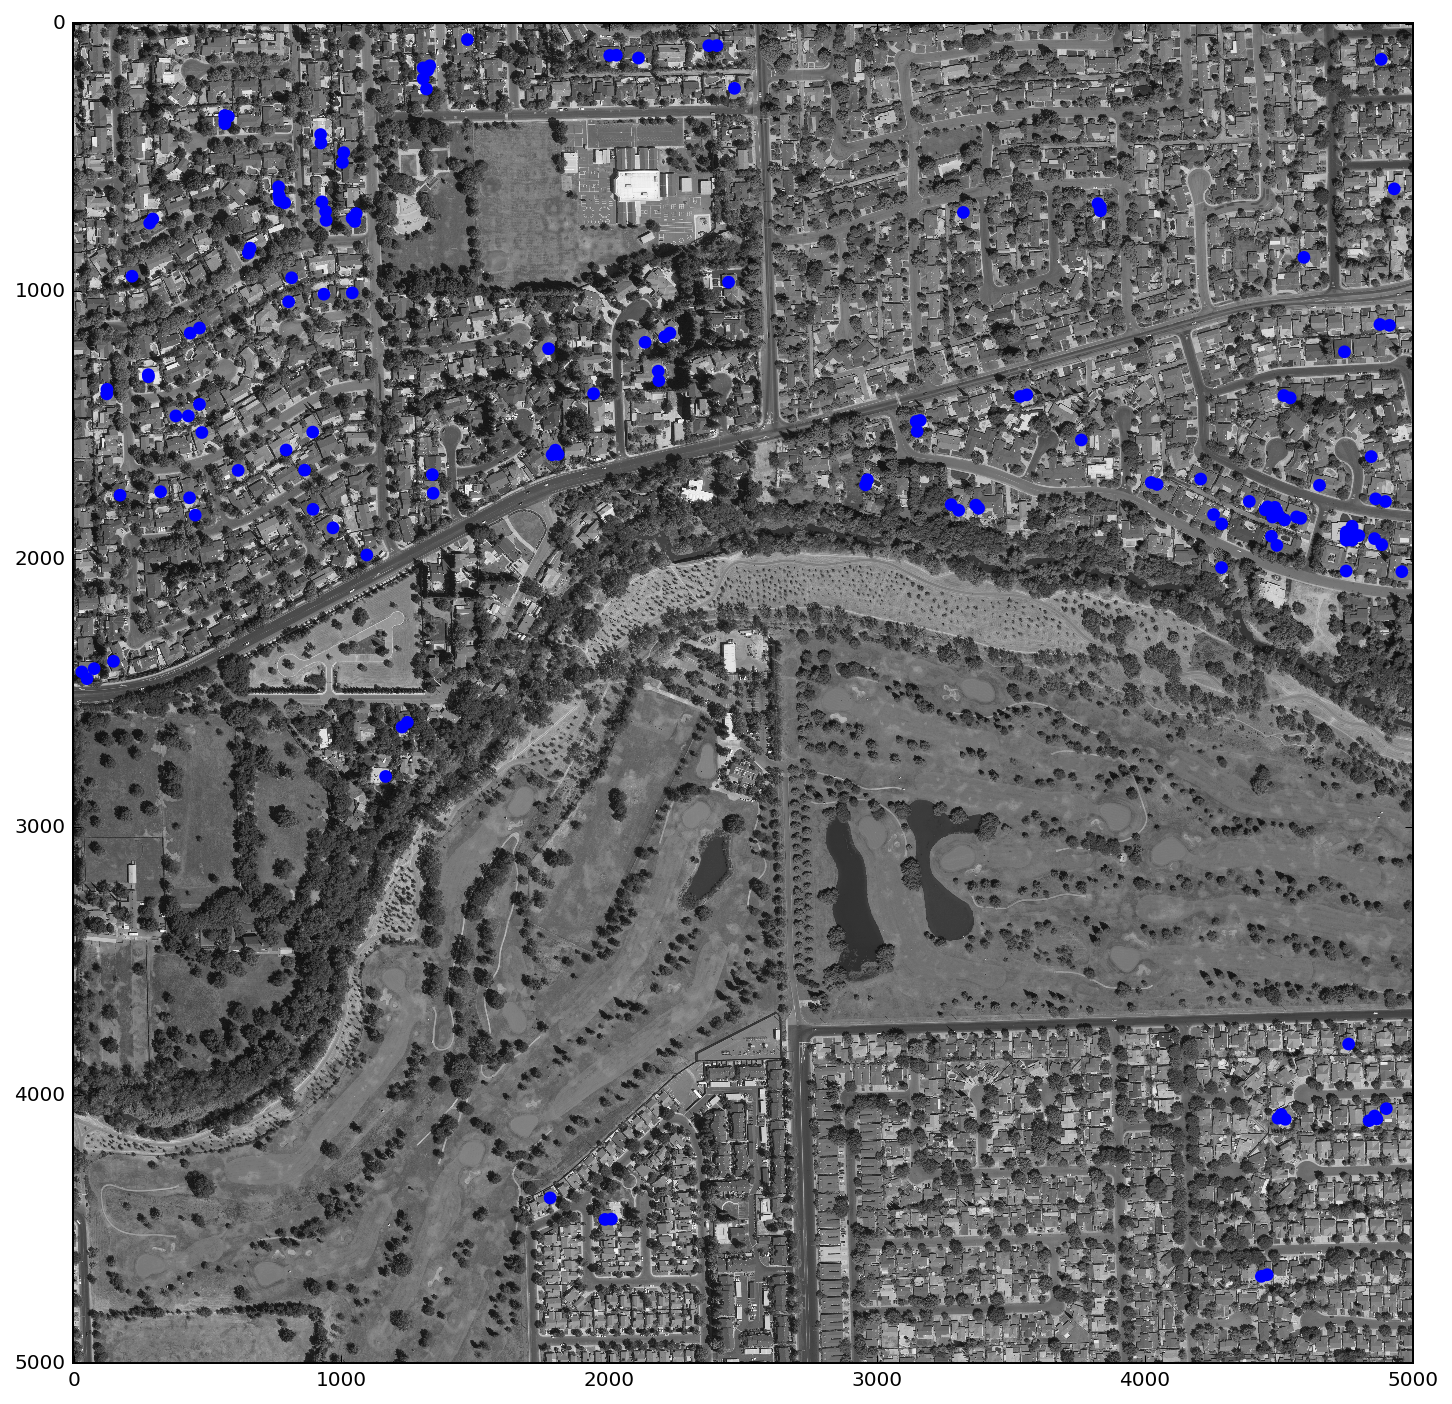

In [20]:
plot_centroids('10sfg810685')

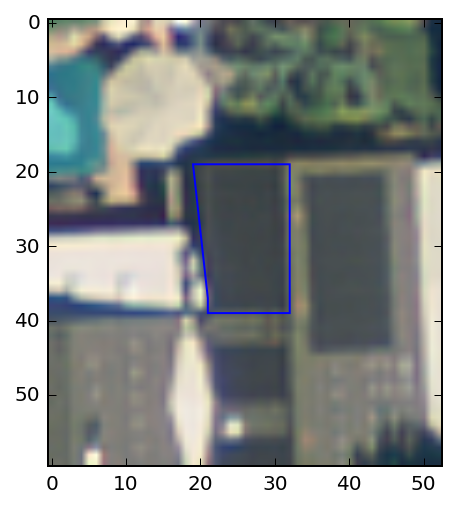

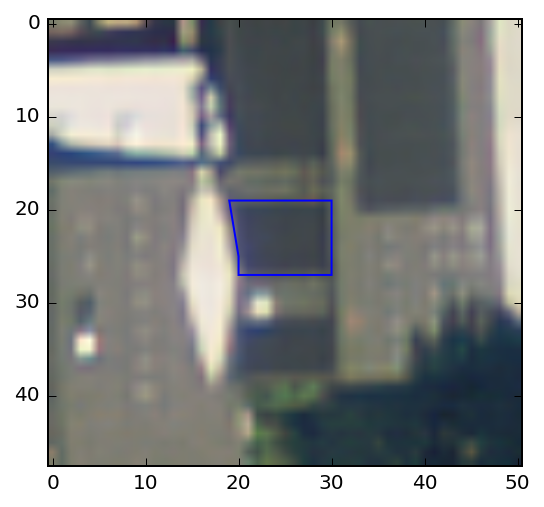

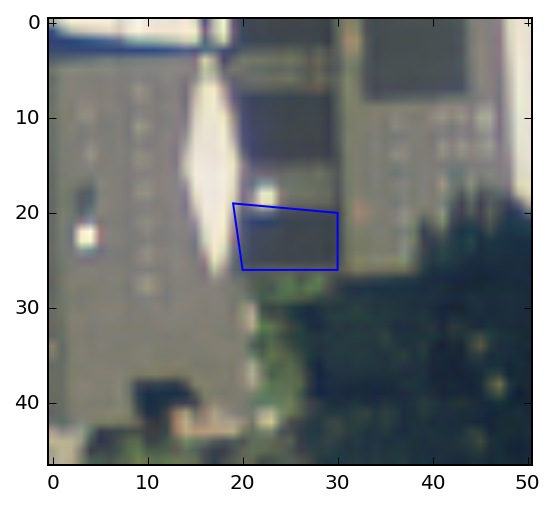

In [21]:
poly_list = arrays_clean[arrays_clean['image_name'] == '10sfg810685']['polygon_id'].values

for poly in poly_list[:3]:
    plot_polygon(poly)

<a href='#Top'>Back to Top</a>
<a id='Section 3'></a>

# Section 3. Image Segmentation
Image segmentation consists of grouping pixels together based on likeness (e.g. color value, proximity). Relevant information can then be extracted and aggregated across each image segment, instead of from the individual pixels themselves. This approach produces a more meaningful model of the image data and simplifies the classification process. Additionally, segment-based classification can often achieve better accuracy than a pixel-based method.

Below is an example segmentation applied to a satellite image containing a solar panel. As you can see, the image has been partitioned into contiguous regions with similar pixel values. 

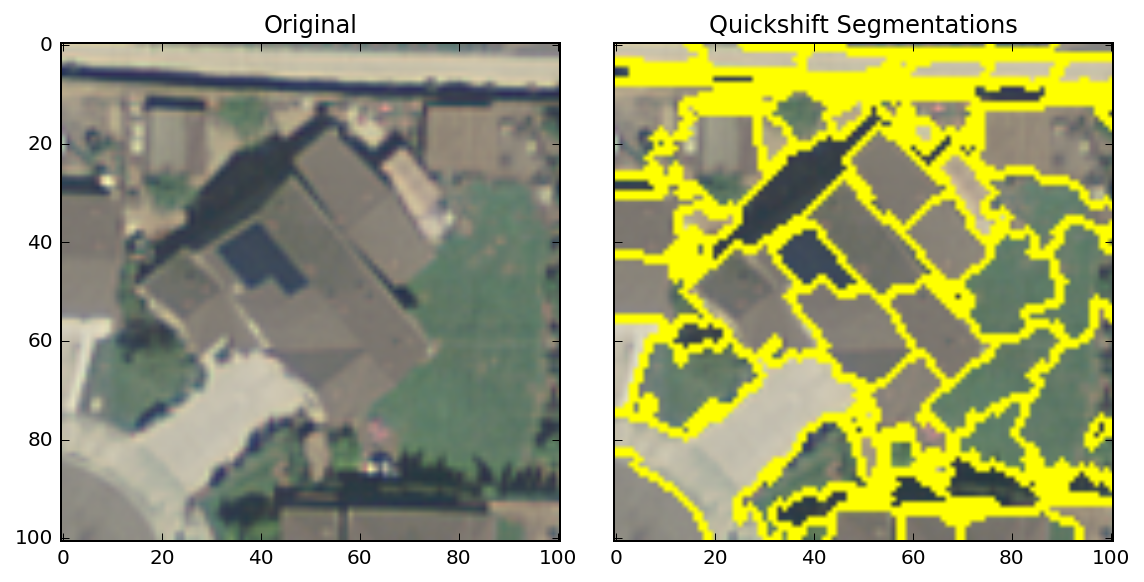

<function __main__.plot_segments>

In [24]:
# Load in sample satellite image 
sample_img = io.imread('/Users/alexanderhalcomb/Desktop/SolarPV/Datasets/Duke KaggleInClass/train_images/image60.tif')

# Use ipywidgets to experiment with algorithm parameters

def plot_segments(img, kernel_size=2, max_dist=10, ratio=0.5):
    
    fig, axes = plt.subplots(1, 2, figsize=(8,4), sharex=True, sharey=True)
    fig.tight_layout()
    
    axes[0].imshow(img)
    axes[0].set_title("Original")

    axes[1].imshow(mark_boundaries(img, quickshift(img, kernel_size=kernel_size, max_dist=max_dist, ratio=ratio)))
    axes[1].set_title("Quickshift Segmentations")

    plt.show()
    
interact(plot_segments, img=fixed(sample_img), kernel_size=(1,10,1), max_dist=(0,20,1), ratio=(0,1,0.1))

The satellite image above is only 100x100 pixels, however, so I will modify the segmentation process for the larger 5000x5000 pixel images. In particular, I will use the annotations data to "segment" the solar panel arrays. In the larger images, solar panels make up a tiny fraction of the total area (< 1.0%). Therefore, to generate the segments that do not contain solar panels, I will sample sections of the image and run the segmentation algorithm on these sections. This process is outlined in <a href='#Section 5'>Section 5: Building a Dataset</a>.

<a href='#Top'>Back to Top</a>
<a id='Section 4'></a>

# Section 4: Feature Extraction
Feature extraction is a key component of image analysis and object detection. I aim to classify segments or superpixels and will therefore calculate features based on these regions of pixels, rather than the pixels themselves. Once a feature set is established, I will then be able to train a classifier to identify regions that are best representative of solar panels. 

In this analysis, features will mostly consist of summary statistics for each color channel (e.g. mean, min, max, variance) but will also include other descriptive values such as area and perimeter.

### Spatial Features
I first define a function to extract spatial features such as area and perimeter. Additionally, I use area and perimeter to calculate a new feature 'circleness' which measures how circular a region is. A value of 1 indicates a perfect circle, whereas a square is ~.80.

In [25]:
# Extract spatial features

def segment_features_shape(segments, img_id='na', quickshift=False):

    # Skimage segmentation algorithms assign a "0" label, however, measure.regionprops only reads labels > 0 
    # If quickshift == True, add 1 to all segment labels
    if quickshift:
        segments = segments + 1
        
    # Convert labels to int and generate unique labels list
    segments = segments.astype(int)
    segment_labels = np.unique(segments[segments > 0])

    # For each region/segment, create regionprops object and extract features
    region_props_all = measure.regionprops(segments)    
    region_features = {}
        
    for i, region in enumerate(region_props_all):    

        shape_features = {}

        shape_features['image_id'] = img_id
        shape_features['segment_id'] = segment_labels[i]
        shape_features['perimeter'] = region.perimeter
        shape_features['area'] = region.area
        shape_features['circleness'] = (4 * np.pi * region.area) / (max(region.perimeter, 1) ** 2)
        shape_features['centroid'] = region.centroid
        shape_features['coords'] = region.coords

        region_features[segment_labels[i]] = shape_features
    
    index = ['image_id', 'segment_id', 'perimeter', 'area', 'circleness', 'centroid', 'coords']
    
    shape_df = pd.DataFrame(region_features, index=index).T
    
    return shape_df


### Color Features
Next, I define a function to extract the color related features. This function iterates through the red, green, and blue channels of the image region and calculates the relevant values.

In [26]:
# Extract color features

def segment_features_color(img, segments, img_id='na', quickshift=False):
    
    # Skimage segmentation algorithms assign a "0" label, however, measure.regionprops only reads labels > 0 
    # If quickshift == True, add 1 to all segment labels
    if quickshift:
        segments = segments + 1
        
    # Convert labels to int and generate unique labels list
    segments = segments.astype(int)
    segment_labels = np.unique(segments[segments > 0])

    # For each segment and channel, calculate summary stats    
    channels = ['r','g','b']    
    region_features = {}
    
    for label in segment_labels:
        region = img[segments == label]
        
        color_features = {}        
               
        for i, channel in enumerate(channels):
            values = describe(region[:,i])
            
            color_features['image_id'] = img_id
            color_features['segment_id'] = label
            color_features[channel + '_min'] = values.minmax[0]
            color_features[channel + '_max'] = values.minmax[1]
            color_features[channel + '_mean'] = values.mean
            color_features[channel + '_variance'] = values.variance
            color_features[channel + '_skewness'] = values.skewness
            color_features[channel + '_kurtosis'] = values.kurtosis
            
        region_features[label] = color_features
        
    index = ['image_id','segment_id','r_min','r_max','r_mean','r_variance','r_skewness',
         'r_kurtosis','g_min','g_max','g_mean','g_variance','g_skewness','g_kurtosis',
         'b_min','b_max','b_mean','b_variance','b_skewness','b_kurtosis']
        
    color_df = pd.DataFrame(region_features, index=index).T
        
    return color_df


<a href='#Top'>Back to Top</a> 
<a id='Section 5'></a>

# Section 5: Building a Dataset
The next step in the image processing pipeline is to define the regions containing solar panels and the regions without any solar panels. Once this mask is defined, features can be calculated, assigned a class, and agreggated together in order to train a classifier. 

In [27]:
# Create a mask for all solar panels in the image, with each labeled by its polygon_id

def panel_mask(img_id, use_labels=False):
  
    # Identify city in order to navigate to correct directory 
    city = arrays_clean[arrays_clean['image_name'] == img_id]['city'].values[0]
    city = 'Duke ' + city
    
    # Read in image
    img = io.imread('/Users/alexanderhalcomb/Desktop/SolarPV/Datasets/%s/%s.tif' % (city, img_id))
    
    # Select polygon vertices for all polygons in image
    vertices = arrays_clean[arrays_clean['image_name'] == img_id]['polygon_vertices'].values
    labels = arrays_clean[arrays_clean['image_name'] == img_id]['polygon_id'].values
    
    # Create scaffolding for mask
    mask = np.zeros((img.shape[0],img.shape[1]))
    mask[mask == 0] = np.nan
        
    # Option to use custom labels for each panel array
    if use_labels == False:
        poly_data = enumerate(vertices, 1)
    else:
        poly_data = zip(labels, vertices)
        
    # Iterate through vertices and assign labels to pixels
    for i, poly in poly_data:
        x = np.array([vert[0] for vert in poly])
        y = np.array([vert[1] for vert in poly])
        
        mask[polygon(x, y, shape=(img.shape[0],img.shape[1]))] = i 
        mask[polygon_perimeter(x, y,shape=(img.shape[0],img.shape[1]))] = i

    return mask


In [28]:
# Create a series of random windows that do not overlap with any solar panels

def no_panel_mask(panel_mask, window_size=100, windows=20):
    
    # Create scaffolding for mask 
    panels = panel_mask.copy() 
    
    mask = np.zeros(panels.shape)
    mask[mask == 0] = np.nan
        
    rows = panels.shape[0]
    cols = panels.shape[1]
        
    # Create i number of random windows with no panels
    for i in range(windows): 
    
        search = True
        
        # Iterate until random window found
        while search:

            random_x = np.random.randint(0, rows - window_size + 1)
            random_y = np.random.randint(0, cols - window_size + 1)
            random_window = panels[random_x: random_x + window_size, random_y: random_y + window_size]

            # End search when random window is all nan, i.e. does not overlap with any panels
            if np.isnan(random_window).sum() == random_window.size:
                
                # Update mask to include new random window
                mask[random_x: random_x + window_size, random_y: random_y + window_size] = i + 1
                
                # Update panel_mask copy to avoid duplicate random window on next iteration
                panels[random_x: random_x + window_size, random_y: random_y + window_size] = 0
                
                # Go to next window 
                search = False
                
    return mask


In [29]:
# Return masks

def return_masks(img_id):
    
    # Create panel mask 
    panels = panel_mask(img_id, use_labels=True)
    
    # Create no panel mask 
    no_panels = no_panel_mask(panels, window_size=60, windows=25)
    
    return panels, no_panels


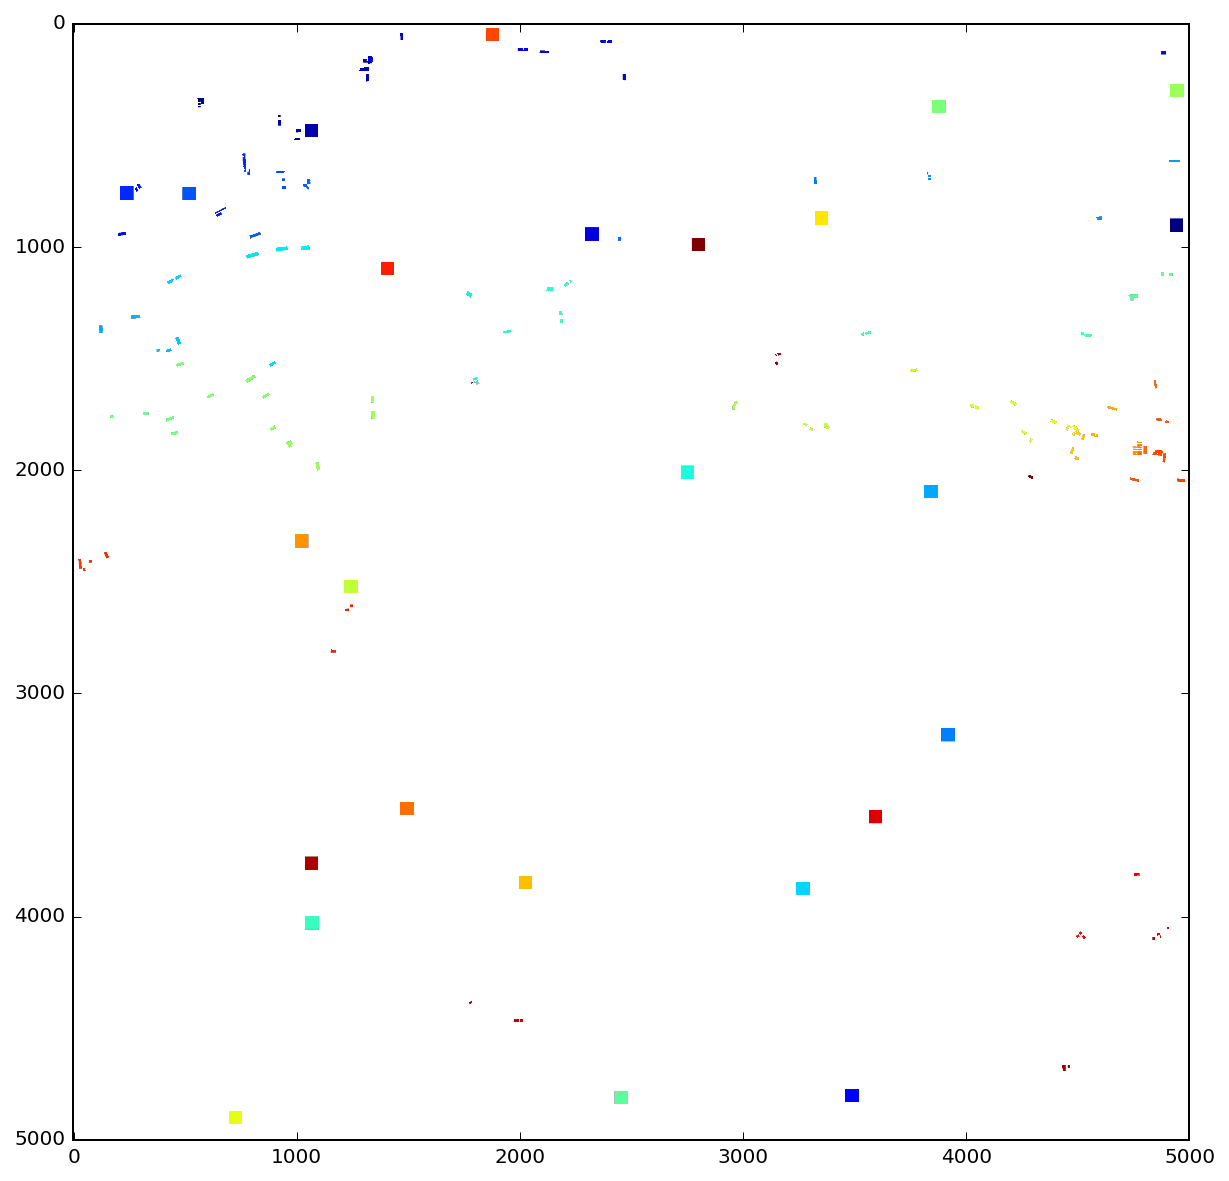

In [34]:
# Create masks for an example image and plot

fig, ax = plt.subplots(figsize=(10,10))

masks = return_masks('10sfg810685')

ax.imshow(masks[0])
ax.imshow(masks[1])
    
plt.show()

In [35]:
# Return features for all solar panels

def extract_pos_features(img_id, quickshift=False):
    
    # Identify city in order to navigate to correct directory 
    city = arrays_clean[arrays_clean['image_name'] == img_id]['city'].values[0]
    city = 'Duke ' + city
    
    # Read in image
    img = io.imread('/Users/alexanderhalcomb/Desktop/SolarPV/Datasets/%s/%s.tif' % (city, img_id))
    
    # Create panel mask 
    segments_panels = panel_mask(img_id, use_labels=True)
    
    # Extract shape features
    shape_df = segment_features_shape(segments_panels, img_id, quickshift=quickshift)
        
    # Extract color features
    color_df = segment_features_color(img, segments_panels, img_id, quickshift=quickshift)

    # Combine features into single dataframe
    features_df = shape_df.merge(color_df, how='inner', on=['image_id','segment_id'])
    
    return features_df


In [36]:
# Return features for regions without solar panels

def extract_neg_features(img_id, window_size=100, windows=20):
    
    # Identify city in order to navigate to correct directory 
    city = arrays_clean[arrays_clean['image_name'] == img_id]['city'].values[0]
    city = 'Duke ' + city
    
    # Read in image
    img = io.imread('/Users/alexanderhalcomb/Desktop/SolarPV/Datasets/%s/%s.tif' % (city, img_id))
                       
    # Create panel mask 
    segments_panels = panel_mask(img_id, use_labels=True)

    # Create no panel mask 
    windows_no_panels = no_panel_mask(segments_panels, window_size=window_size, windows=windows)
    windows_labels = np.unique(windows_no_panels[windows_no_panels > 0])

    frames = []
    
    for label in windows_labels:

        # Extract window from image
        window_img = img[windows_no_panels == label].reshape((window_size, window_size, 3))
        
        # Divide window into segments using Quickshift segmentation algorithm 
        segments_quick = quickshift(window_img, kernel_size=3, max_dist=8, ratio=0.65)
        segments_labels = np.unique(segments_quick)

        # Extract shape features
        shape_df = segment_features_shape(segments_quick, img_id, quickshift=True) 

        # Extract color features
        color_df = segment_features_color(window_img, segments_quick, img_id, quickshift=True)

        # Combine features into single dataframe
        features_df = shape_df.merge(color_df, how='inner', on=['image_id','segment_id'])
        
        # Append to list to facilitate aggregation
        frames.append(features_df)
        
    return pd.concat(frames)


In [37]:
# Input image(s) and feed through entire pipeline, return df of results

def process_images(images):
    
    frames = []
    
    for img_id in images:
        
        pos_features = extract_pos_features(img_id)
        pos_features['panel_class'] = 1

        neg_features = extract_neg_features(img_id, window_size=60, windows=25)
        neg_features['panel_class'] = 0

        combined_features = pd.concat([pos_features, neg_features])
        combined_features.dropna(inplace=True)
        
        frames.append(combined_features)
    
    return pd.concat(frames).reset_index(drop=True)

<a href='#Top'>Back to Top</a> 
<a id='Section 6'></a>

# Section 6: Classification 
In this section, a Logistic Regression and Random Forest Classifier will be trained and evaluated on the test data.

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.cross_validation import cross_val_score, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV

from sklearn.metrics import confusion_matrix, precision_recall_curve, classification_report
from sklearn.metrics import roc_curve, auc

In [39]:
combined_features = pd.read_pickle('/Users/alexanderhalcomb/Desktop/DSI-SF-2-alexhalcomb/Capstone/combined_features3.p')
combined_features.shape

(46707, 26)

In [40]:
# Create X and y data

excluded = ['panel_class', 'image_id', 'segment_id', 'centroid', 'coords', 'r_skewness', 
            'g_skewness', 'b_skewness','r_kurtosis', 'g_kurtosis', 'b_kurtosis']

X_cols = [col for col in combined_features.columns if col not in excluded]

ss = StandardScaler()

X = combined_features[X_cols]
Xn = ss.fit_transform(X)

y = combined_features['panel_class']
y_base = max(np.mean(y), 1 - np.mean(y))

# Split data into a training and testing set

X_train, X_test, y_train, y_test = train_test_split(Xn, y, test_size=0.3, stratify=y)

print X_train.shape, X_test.shape
print y_train.shape, y_test.shape

(32694, 15) (14013, 15)
(32694,) (14013,)


In [46]:
# Function to plot precision recall curve

def plot_precision_recall(y_true, y_prob, title='Precision Recall Curve'):
    
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)

    fig, ax = plt.subplots(figsize=(7,5))

    plt.plot(recall, precision, 'b')
    plt.plot([1,0], [0,1], '--r')
    
    plt.title(title, fontsize=16)   
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)

    plt.show()


In [47]:
# Function to plot ROC curve

def plot_roc(y_true, y_prob, title='Receiver Operating Characteristic'):
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(false_positive_rate, true_positive_rate)

    fig, ax = plt.subplots(figsize=(7,5))

    plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.3f'% roc_auc)
    plt.plot([0,1],[0,1],'r--')
    
    plt.title(title, fontsize=16)
    plt.xlabel('False Positive Rate (Fall-out)', fontsize=14)
    plt.ylabel('True Positive Rate (Recall)', fontsize=14)
    plt.legend(loc='lower right')

    plt.show()


In [63]:
# Function to plot confusion matrix, normalized=True returns cm in the form of percentages

def plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.Greens, normalize=False, title='Confusion Matrix'):
    
    matrix = confusion_matrix(y_true, y_pred, labels=[1,0])

    fig, axes = plt.subplots(figsize=(5,5))
    fig.tight_layout()
    
    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
        plt.title(title, fontsize=16)
    else:
        plt.title(title, fontsize=16)
        
    classes = ['Solar Panels','None']
    ticks = np.arange(len(classes))

    plt.imshow(matrix, interpolation='nearest', cmap=cmap)

    thresh = matrix.max() / 2.
    
    for row in range(matrix.shape[0]):
        for col in range(matrix.shape[1]):
            plt.text(col, row, np.around(matrix[row, col], decimals=3), horizontalalignment='center', 
                     color='white' if matrix[row, col] > thresh else 'black', fontsize=14)
    
    plt.xticks(ticks, classes, rotation=45)
    plt.yticks(ticks, classes, rotation=45)
    
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    
    plt.colorbar()
    plt.show()


### Logistic Regression

I've chosen to use Logistic Regression due to its simplicity and interpretability. The initial results are encouraging, with an accuracy of 96% on the testing data, compared to a baseline accuracy of 91%. As seen in the graph of coefficient values below, the features that are most meaningful are the mean color values, area, and circleness. 

In [41]:
# GridSearch a LogisticRegression classifier

lr = LogisticRegression()

lr_params = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.linspace(0.0001, 500, 50)
}

lr_gs = GridSearchCV(lr, lr_params, cv=5, verbose=1)
lr_gs.fit(X_train, y_train)
print 'Done fitting.'

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   33.2s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:  2.6min
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:  6.0min
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  6.7min finished


Done fitting.


In [42]:
# Check results of Logistic Regression GridSearch

lr_best = lr_gs.best_estimator_
print 'Logistic Regression GridsearchCV Results:'
print 'Best Estimator', lr_best
print 'Best Parameters',  lr_gs.best_params_
print 'Best Score', '%0.4f' % lr_gs.best_score_, '\n'

# Check results against hold out test set 

print 'Cross Validation on Test Set:'
print 'Score: ', '%0.4f' % lr_gs.score(X_test, y_test)
print 'Baseline Accuracy: ', '%0.4f' % y_base
print 'Percent Better: ', '%0.4f' % ((lr_gs.score(X_test, y_test) - y_base) / (1 - y_base))

Logistic Regression GridsearchCV Results:
Best Estimator LogisticRegression(C=10.204179591836734, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Best Parameters {'penalty': 'l1', 'C': 10.204179591836734, 'solver': 'liblinear'}
Best Score 0.9666 

Cross Validation on Test Set:
Score:  0.9672
Baseline Accuracy:  0.9132
Percent Better:  0.6225


In [49]:
# Extract Logistic Regression coefs

coefs = pd.DataFrame({'feature': X.columns,
                      'abs_coef': [abs(coef) for coef in lr_best.coef_[0]],
                      'coef': lr_best.coef_[0]}, columns=['feature','abs_coef','coef'])
coefs.sort_values('abs_coef', ascending=False, inplace=True)

coefs

feature  abs_coef      coef
13      b_mean  5.831911  5.831911
5       r_mean  5.622082 -5.622082
1         area  4.533141  4.533141
2   circleness  3.934788 -3.934788
3        r_min  2.710377  2.710377
4        r_max  2.692851  2.692851
9       g_mean  2.308361 -2.308361
12       b_max  2.232423 -2.232423
0    perimeter  2.038443 -2.038443
11       b_min  1.691504 -1.691504
10  g_variance  1.386157  1.386157
6   r_variance  1.186864  1.186864
8        g_max  0.463736  0.463736
7        g_min  0.372963  0.372963
14  b_variance  0.068114 -0.068114

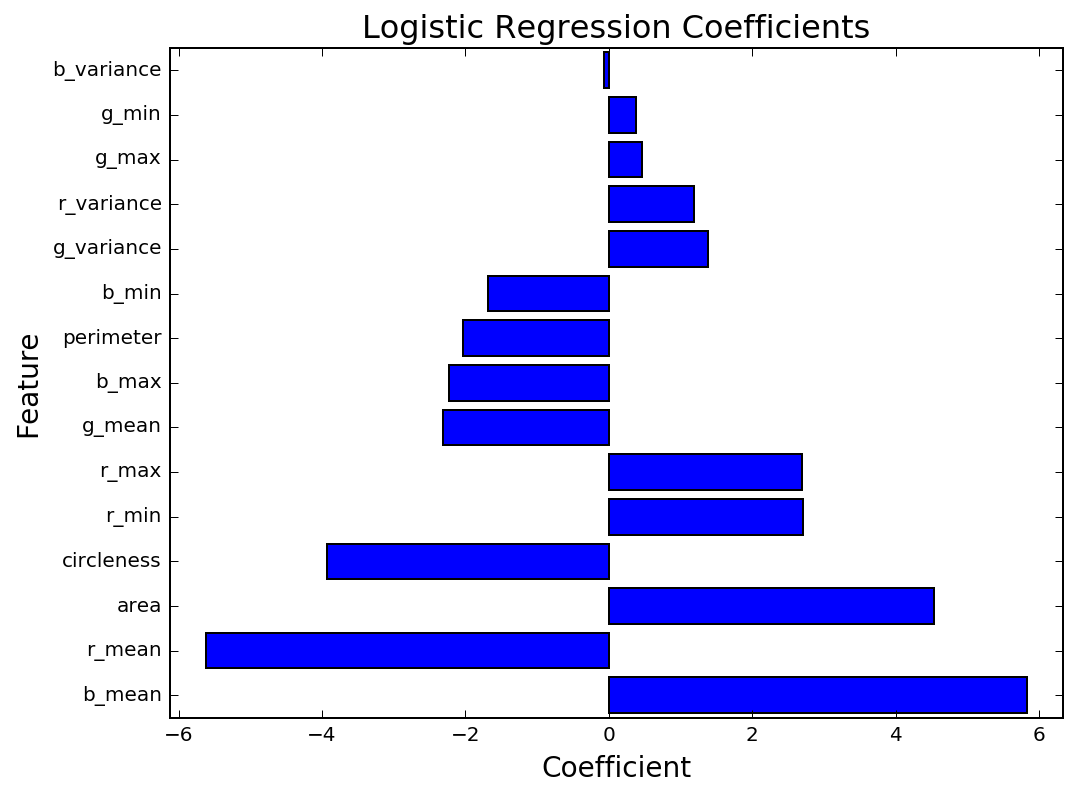

In [58]:
# Plot Logistic Regression coefs 

fig, ax = plt.subplots(figsize=(8, 6))

ax.barh(np.arange(len(coefs['abs_coef'].values)), coefs['coef'], 0.8, align='center')

ax.set_yticks(np.arange(len(coefs['abs_coef'].values)))
ax.set_yticklabels(coefs['feature'], fontsize=10)
ax.set_ylabel('Feature', fontsize=14)
ax.set_xlabel('Coefficient', fontsize=14)
ax.set_ylim([-0.5, 14.5])
ax.set_xlim([coefs['coef'].min()-0.5, coefs['coef'].max()+0.5])
ax.set_title('Logistic Regression Coefficients', fontsize=16)
plt.show()

### Random Forest

Decision Tree models are comprised of a series of nodes, or decisions, where an element of the data is tested e.g. x > 5. These tests are derived by evaluating how effective they are at dividing the data into homogenous groups. 

A Random Forest is simply a collection of Decision Tree models, where each Decision Tree is fit on a random sample of the data. Random Forests are very powerful and are adept at learning complicated, non-linear relationships. 

By using many Decision Trees on multiple versions of the dataset, overfitting can be avoided. This reduces model variance significantly with only a small increase in bias. This is a key advantage of using ensemble methods. For this reason, I've chosen to use a Random Forest Classifier. The Random Forest outperforms the Logistic Regression, with an accuracy of 98% compared to a baseline accuracy of 91%. As with the Logistic Regression, the Random Forest placed high importance on the area and circleness features. However, the Random Forest feature importances show that the most important features were the color variances.

In [43]:
# GridSearch a RF classifier

rf = RandomForestClassifier()

rf_params = {
    'max_features':[None,'log2','sqrt', 2,3,4,5],
    'max_depth':[1,2,3,None],
    'min_samples_leaf':np.linspace(1,101,20),
    'n_estimators':[50]
}

rf_gs = GridSearchCV(rf, rf_params, cv=5, verbose=1, n_jobs=-1)
rf_gs.fit(X_train, y_train)
print 'Done fitting.'

Fitting 5 folds for each of 560 candidates, totalling 2800 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 17.2min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 34.4min
[Parallel(n_jobs=-1)]: Done 2800 out of 2800 | elapsed: 43.5min finished


Done fitting.


In [44]:
# Check results of Random Forest GridSearch

rf_best = rf_gs.best_estimator_
print 'Random Forest GridsearchCV Results:'
print 'Best Estimator', rf_best
print 'Best Parameters',  rf_gs.best_params_
print 'Best Score', '%0.4f' % rf_gs.best_score_, '\n'

# Check results against hold out test set 

print 'Cross Validation on Test Set:'
print 'Score: ', '%0.4f' % rf_gs.score(X_test, y_test)
print 'Baseline Accuracy: ', '%0.4f' % y_base
print 'Percent Better: ', '%0.4f' % ((rf_gs.score(X_test, y_test) - y_base) / (1 - y_base))

Random Forest GridsearchCV Results:
Best Estimator RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=4, max_leaf_nodes=None,
            min_samples_leaf=1.0, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Best Parameters {'max_features': 4, 'n_estimators': 50, 'max_depth': None, 'min_samples_leaf': 1.0}
Best Score 0.9796 

Cross Validation on Test Set:
Score:  0.9782
Baseline Accuracy:  0.9132
Percent Better:  0.7484


In [59]:
# Extract RF feature importance

feature_importance = pd.DataFrame({'feature': X.columns,
                                   'importance': rf_best.feature_importances_})

feature_importance.sort_values('importance', ascending=False, inplace=True)

feature_importance

feature  importance
10  g_variance    0.277163
6   r_variance    0.163567
14  b_variance    0.119360
2   circleness    0.078262
1         area    0.068399
5       r_mean    0.040928
0    perimeter    0.035701
3        r_min    0.035099
9       g_mean    0.033607
13      b_mean    0.027164
4        r_max    0.026561
11       b_min    0.025839
7        g_min    0.024308
12       b_max    0.023908
8        g_max    0.020133

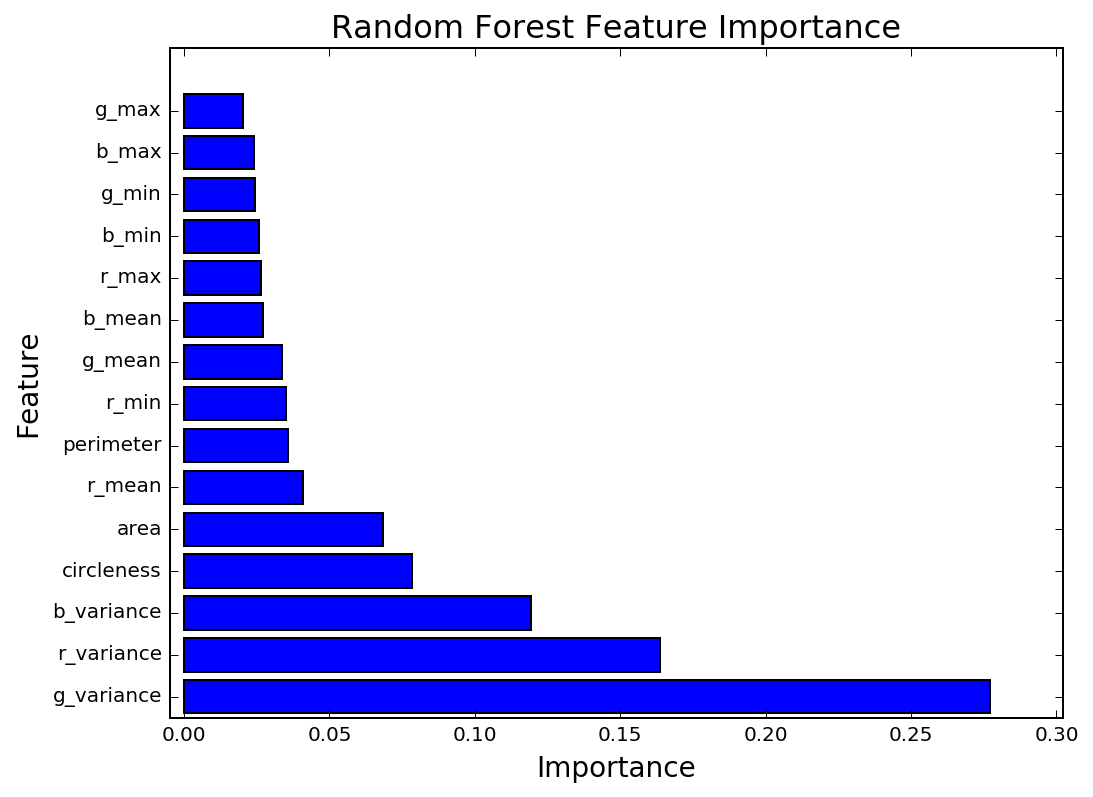

In [60]:
# Plot RF feature importance

fig, ax = plt.subplots(figsize=(8, 6))

ax.barh(np.arange(len(feature_importance['importance'].values)), feature_importance['importance'], 0.8, align='center')

ax.set_yticks(np.arange(len(feature_importance['importance'].values)))
ax.set_yticklabels(feature_importance['feature'], fontsize=10)
ax.set_ylabel('Feature', fontsize=14)
ax.set_xlabel('Importance', fontsize=14)
ax.set_ylim([-0.5, 15.5])
ax.set_xlim([feature_importance['importance'].min()-0.025, feature_importance['importance'].max()+0.025])
ax.set_title('Random Forest Feature Importance', fontsize=16)
plt.show()

To evaluate the performance of this classifier, I will compare the model predictions against the true values. When the dataset is strongly imbalanced, as is the case here, this can be a much more intuitive way to analyze the results. To visualize this I will use a Confusion Matrix, which shows the proportion of correct/incorrect model predictions.

In [45]:
# Create variables for class predictions and probability predictions

y_pred_lr = lr_gs.predict(X_test)
y_prob_lr = lr_gs.predict_proba(X_test)[:,1]

y_pred_rf = rf_gs.predict(X_test)
y_prob_rf = rf_gs.predict_proba(X_test)[:,1]

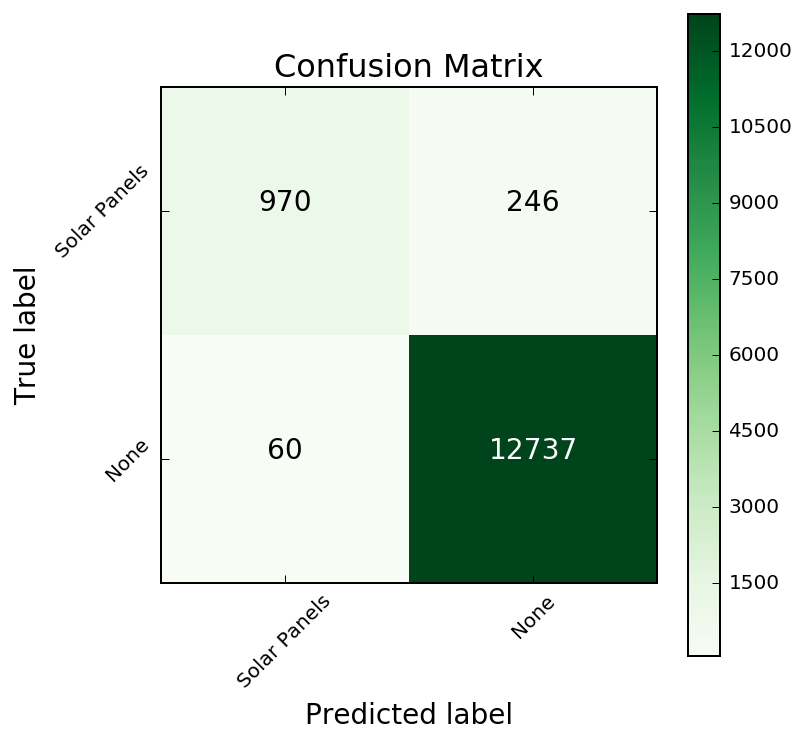

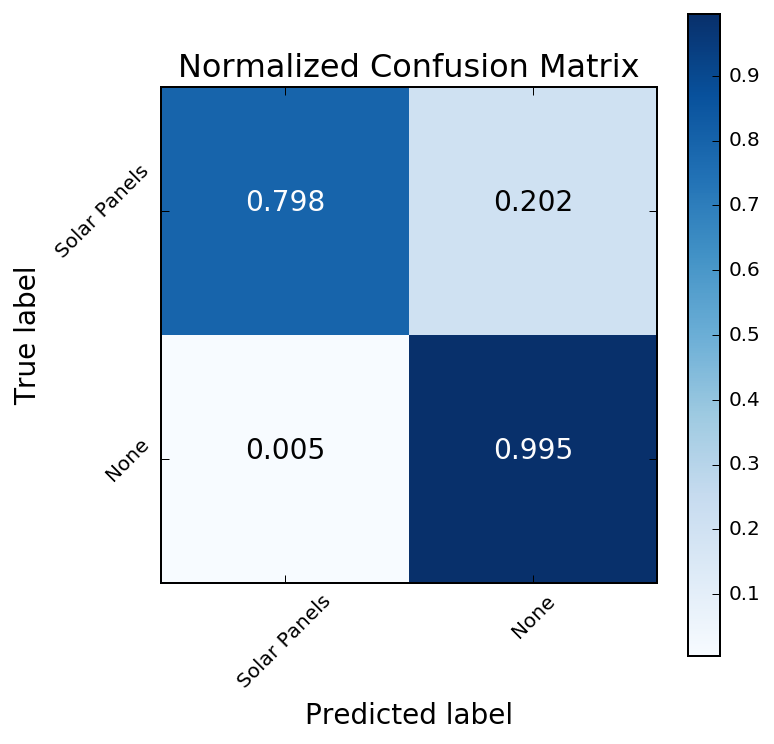

In [65]:
plot_confusion_matrix(y_test, y_pred_rf, title='Confusion Matrix')
plot_confusion_matrix(y_test, y_pred_rf, normalize=True, cmap=plt.cm.Blues, title='Normalized Confusion Matrix')

The Receiver Operating Characteristic curve measures the True Positive Rate or Recall (TP / TP + FN) against the False Positive Rate (FP / FP + TN). There is a tradeoff between and the two and plotting the ROC is a helpful way to analyze the effectiveness of a classifier. 

In this analysis, the True Positive Rate measures how many solar panels are being correctly classified, out of the total number of solar panels in the image. As this ratio increases, however, the number of non panel regions that are being misclassified as solar panels also increases. The AUC, or Area Under the Curve, is a common way to quantify this tradeoff. An AUC of 1 reflects perfect classification.

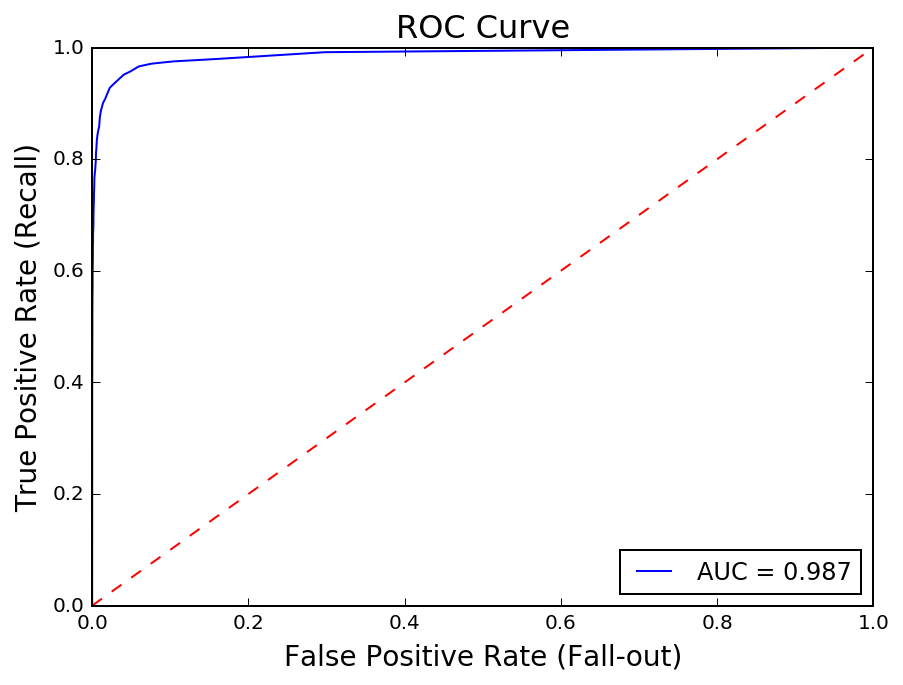

In [104]:
plot_roc(y_test, y_prob_rf, title= 'ROC Curve')

The Precision Recall curve is closely related to the ROC curve in that both reflect tradeoffs. Instead of the False Positive Rate, however, Recall is compared to Precision which measures the number of true positives out of total positive predictions (TP / TP + FP). 

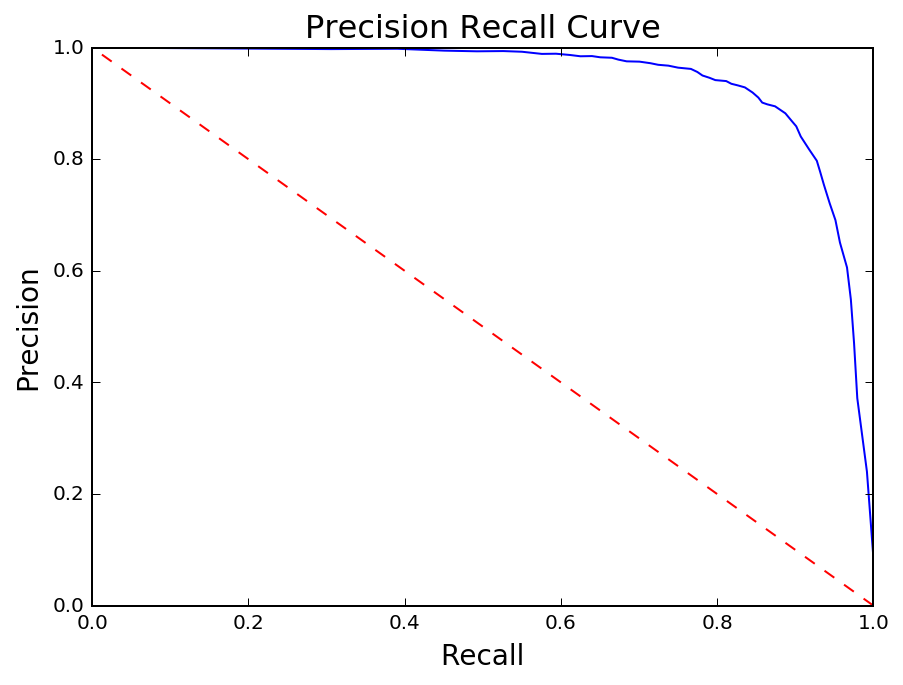

In [105]:
plot_precision_recall(y_test, y_prob_rf, title='Precision Recall Curve')

### Misclassified

Around 20% of the solar panels are being misclassified as 'not a solar panel' using the current model. I will examine the false negatives with the lowest predicted probabilities in order to better understand where the model is failing the worst. 

In [106]:
# Use classifier outputs to return dataframe with false positives, false negatives, and associated probabilities

def misclassified(y_true, y_prob, y_pred, error='all'):

    y_prob_series = pd.Series(y_prob, index=y_true.index)
    
    misclassified = pd.DataFrame({'y_true': y_true, 
                                  'y_pred': y_pred,
                                  'y_prob': y_prob_series}, 
                                 columns=['y_true', 'y_pred', 'y_prob'])

    misclassified = misclassified[misclassified['y_true'] != misclassified['y_pred']]
    misclassified['kind'] = misclassified['y_true'].map(lambda x: 'fp' if x == 0 else 'fn')
    misclassified.reset_index(inplace=True)
        
    fn = misclassified[misclassified['kind'] == 'fn'].sort_values(by='y_prob')
    fp = misclassified[misclassified['kind'] == 'fp'].sort_values(by='y_prob', ascending=False)
    
    if error == 'all':
        return misclassified
    elif error == 'fn':
        return fn
    else:
        return fp


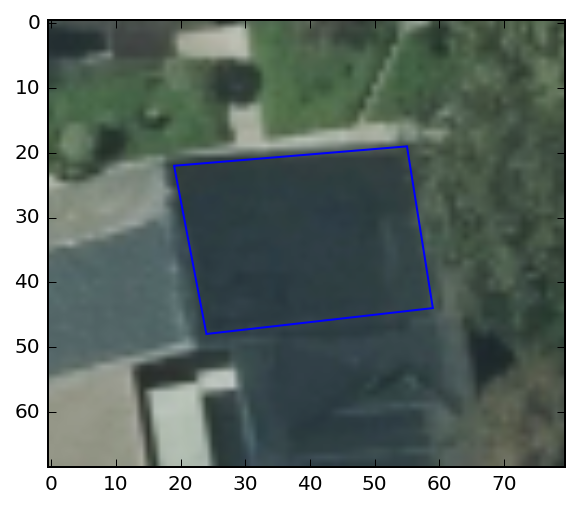

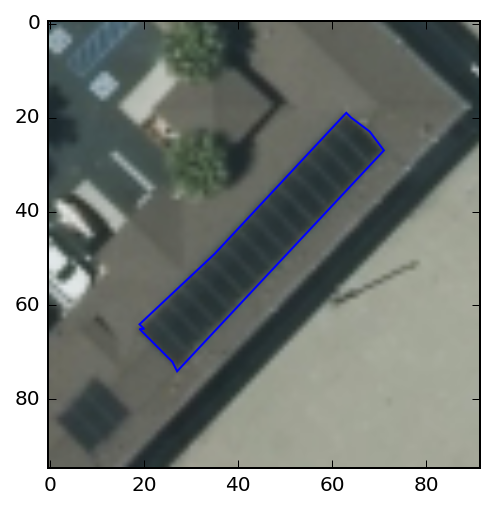

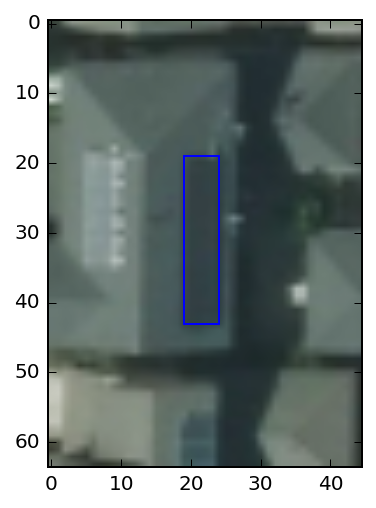

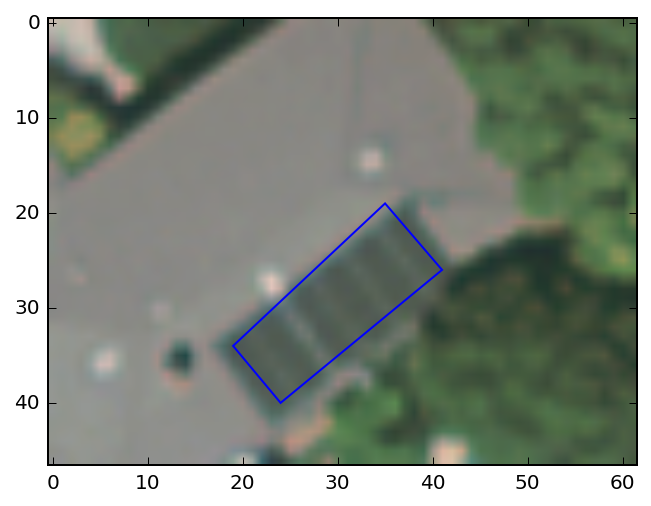

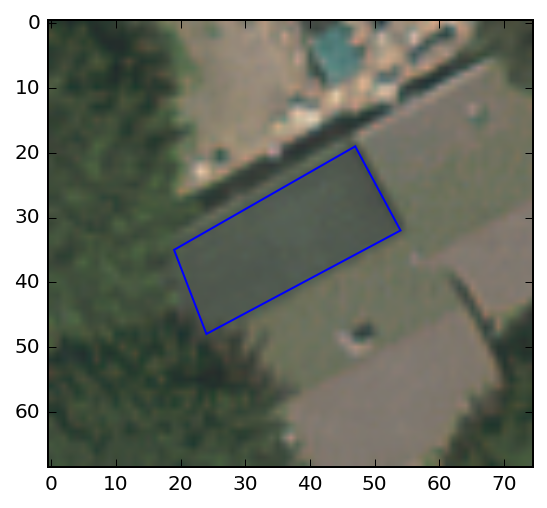

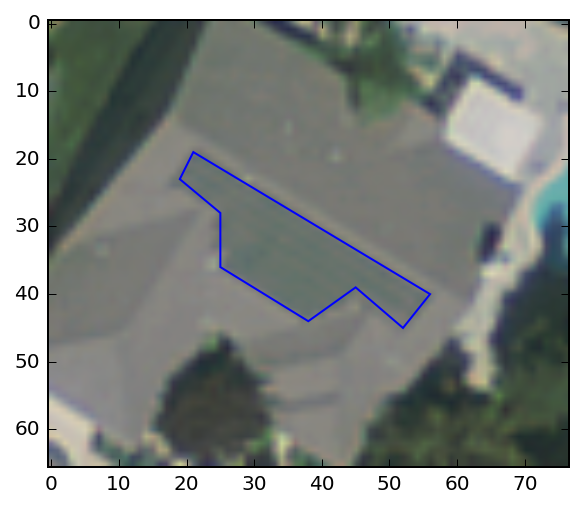

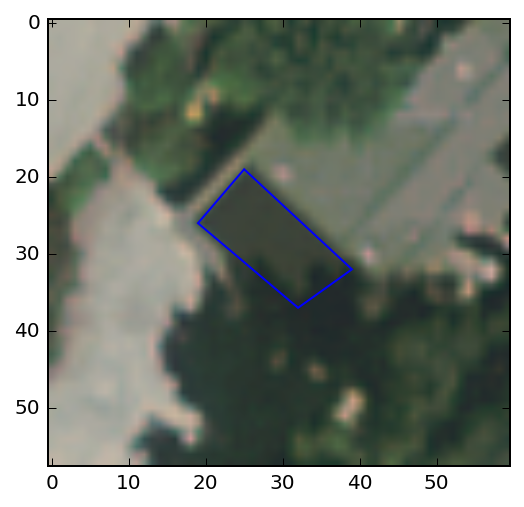

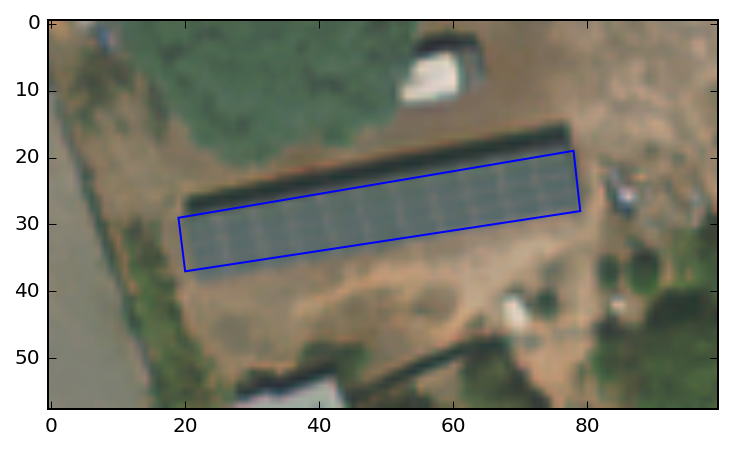

In [113]:
# Plot false negatives with lowest 'panel' probability

fn_ids = misclassified(y_test, y_prob_rf, y_pred_rf, error='fn')['index'].values[:8]
fn_poly_ids = combined_features[combined_features.index.isin(fn_ids)]['segment_id'].values
fn_poly_images = combined_features[combined_features.index.isin(fn_ids)]['image_id'].values

for img, poly in zip(fn_poly_images, fn_poly_ids):
    plot_polygon(poly)

<a href='#Top'>Back to Top</a> 
<a id='Section 7'></a>

# Section 7: Conclusion and Next Steps

The results from this analysis demonstrate that it is possible to succesfully use satellite imagery to detect objects of interest. In this case, the pixel characteristics of solar panels uniquely identify them within a large background. Going forward, there are a number of areas for further improvement. 

#### Problematic Panels
It's clear that there are two types of solar panels that have proven difficult to detect. Panels that appear very light in color, and those that show significant grid lines. In the first instance, the panels tend to blend in with the roof of the building and are therefore difficult to distinguish. In the second case, the color values and variance are skewed relative to the rest of the dataset.

#### Images in the Wild
The end goal for this project is to classify solar panels in images that have not been annotated. I have begun the process of generalizing this framework to images 'in the wild'. The key challenges will be as follows:

1. Segmentation - Ensuring that the entirety of a solar panel is included in its own region. Will require fine tuning of segmentation algorithm parameters and potentially pre-segmentation image processing (filters, denoising, etc.).
2. Modify Classifier - Bridging the gap between the data that the classifier trained on and what will be outputted from a new image. Specifically, solar panel annotations in the ground truth dataset do not necessarily match up with what a segmentation algorithm will extract for a solar panel region.